In [1]:
import cplex

In [2]:
cplex.__path__  # make sure the path is the one we pick above

['/Applications/CPLEX_Studio1210/cplex/python/3.6/x86-64_osx/cplex']

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util_io import (
    init, finalize, dump_conf, assigned_day_to_family_on_day, assigned_day_to_occupancy
)
from util_cost import (
    cal_total, n_people, family_id_choice_to_pref_cost, cal_total_preference, cal_total_accounting,
    nd_ndp1_to_account_penality, fixed_family_cost, fixed_person_cost
)
from util_cost import choices as family_pref
from util_check import deep_check, check_valid_all

In [4]:
# constants #
N_families = 5000
N_days = 100
N_min_people = 125
N_max_people = 300
# constants #

# params #
path_occupancy_pairs_input = '../output/a03-occupancy-pairs.csv'
path_occupancy_pairs_output = '../output/a04-occupancy-pairs.csv'

num_cpu_cores = 6
#time_limit = -1 # unlimited
time_limit = 3*60*60*1000  # in s

# occupancy_diff = 2  # +- the occupancy of input solution for each day
max_family_rank = 7  # maximum number of rank of the preference days for each family
# use_hint = True      # use current input as hint
# occupancy_count_as_variables = False  # use occupancy_counts as variable
# min_choice_0_families = 3000   # minimum number of families that are at their choice 0
# target_pref_cost = 62868
target_accounting_cost = 6020.043432
target_accounting_cost_error = 0.0001

In [9]:
allowed_occupancy = range(N_min_people, N_max_people+1)

In [10]:
total_people = n_people.sum()
print(total_people)

21003


## CPLEX MIP solver

In [5]:
from docplex.mp.model import Model

In [6]:
solver = Model('')

In [7]:
if num_cpu_cores > 0:
    solver.context.cplex_parameters.threads = num_cpu_cores
    print('Set num threads:', num_cpu_cores)
print('Num treads:', solver.context.cplex_parameters.threads)
if time_limit > 0:
    print('Set time limit:', solver.set_time_limit(time_limit))

Set num threads: 6
Num treads: threads:int(6)
Set time limit: None


In [8]:
solver.parameters.mip.tolerances.mipgap = target_accounting_cost_error

In [11]:
# Occupancy pairs counts [N_d, N_d+1]: n of days at that pair
occupancy_pairs_counts = solver.integer_var_matrix(
    allowed_occupancy, allowed_occupancy, lb=0, ub=N_days, name='o'
)

In [12]:
accounting_cost = solver.sum([
    occupancy_pairs_counts[o, o_next] * nd_ndp1_to_account_penality[o, o_next]
    for o in allowed_occupancy for o_next in allowed_occupancy
])

In [13]:
# at least 1 day with o == o_next
solver.add_constraint_(
    solver.sum([occupancy_pairs_counts[o, o] for o in allowed_occupancy]) >= 1
)

In [14]:
# first day is N_max_people = 300
solver.add_constraint_(solver.sum([occupancy_pairs_counts[N_max_people, o] for o in allowed_occupancy]) >= 1)

In [15]:
# occupancy counts from outgoing
occupancy_outgoing_counts = {
    # outgoing of the o
    o: solver.sum([occupancy_pairs_counts[o, o_other] for o_other in allowed_occupancy])    
    for o in allowed_occupancy
}
# occupancy counts from incoming
occupancy_incoming_counts = {
    # incoming of the o
    o: solver.sum([occupancy_pairs_counts[o_other, o] for o_other in allowed_occupancy])
    - (1 if o == N_min_people else 0) + (1 if o == N_max_people else 0)
    for o in allowed_occupancy
}

In [16]:
# o and o_next consistent (assume first day is 300 last day is 125)
for o in allowed_occupancy:
    solver.add_constraint_(
        occupancy_outgoing_counts[o] == occupancy_incoming_counts[o]
    )

In [17]:
# sum occupancy == total_people
solver.add_constraint_(
    solver.sum([occupancy_outgoing_counts[o] * o for o in allowed_occupancy]) == total_people
)

In [18]:
# constraint targe accounting cost
# solver.add_constraint_(accounting_cost <= target_accounting_cost + target_accounting_cost_error)
# solver.add_constraint_(accounting_cost >= target_accounting_cost - target_accounting_cost_error)
solver.add_range(target_accounting_cost - target_accounting_cost_error, 
                 accounting_cost,
                 target_accounting_cost + target_accounting_cost_error
                )

docplex.mp.RangeConstraint[](6020.042432,0.031o_126_125+0.028o_126_126+0.031o_126_127+0.034o_126_128+0.038o_126_129+0.041o_126_130+0.046o_126_131+0.050o_126_132+0.055o_126_133+0.061o_126_134+0.067o_126_135+0.074o_126_136+0.081o_126_137+0.090o_126_138+0.099o_126_139+0.109o_126_140+0.120o_126_141+0.132o_126_142+0.145o_126_143+0.160o_126_144+0.176o_126_145+0.194o_126_146+0.214o_126_147+0.236o_126_148+0.260o_126_149+0.286o_126_150+0.315o_126_151+0.347o_126_152+0.382o_126_153+0.421o_126_154+0.464o_126_155+0.511o_126_156+0.563o_126_157+0.620o_126_158+0.683o_126_159+0.752o_126_160+0.829o_126_161+0.913o_126_162+1.006o_126_163+1.108o_126_164+1.220o_126_165+1.344o_126_166+1.481o_126_167+1.631o_126_168+1.797o_126_169+1.979o_126_170+2.180o_126_171+2.401o_126_172+2.645o_126_173+2.914o_126_174+3.210o_126_175+3.536o_126_176+3.895o_126_177+4.291o_126_178+4.726o_126_179+5.206o_126_180+5.735o_126_181+6.317o_126_182+6.959o_126_183+7.666o_126_184+8.444o_126_185+9.302o_126_186+10.247o_126_187+11.287o_126_1

In [19]:
solver.minimize(accounting_cost)

### Solve

In [20]:
from docplex.mp.progress import TextProgressListener
from docplex.mp.progress import ProgressClock

In [21]:
# print progress
solver.add_progress_listener(
    TextProgressListener(clock=ProgressClock.All, absdiff=10)
)  
# clock=ProgressClock.Objective, absdiff=10
# ProgressClock.All

In [22]:
print('N of variables (binary, int):', solver.number_of_variables, 
      '(', solver.number_of_binary_variables, ',', solver.number_of_integer_variables, ')')
print('N of constraints:', solver.number_of_constraints)
print('Time limit:', solver.get_time_limit())

N of variables (binary, int): 30976 ( 0 , 30976 )
N of constraints: 180
Time limit: 10800000.0


In [23]:
%%time
# Solve
sol = solver.solve()

print('Solution status:', solver.get_solve_status())
print('Total cost:', sol.objective_value, sol.get_objective_value())
print("Time:", '%.3f' % solver.get_solve_details().time, "s")

  1 : Node=0 Left=1 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=399 [0.8s]
  2 : Node=0 Left=1 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=399 [0.8s]
  3 : Node=0 Left=1 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=400 [0.8s]
  4 : Node=0 Left=1 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=442 [1.0s]
  5 : Node=0 Left=1 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=442 [1.0s]
  6 : Node=0 Left=1 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=443 [1.1s]
  7 : Node=0 Left=1 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=443 [1.1s]
  8 : Node=0 Left=1 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=443 [2.9s]
  9 : Node=1 Left=1 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=443 [2.9s]
 10 : Node=2 Left=2 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=444 [2.9s]
 11 : Node=3 Left=3 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=447 [2.9s]
 12 : Node=4 Left=4 Best Integer=N/A, Best Bound=6020.

 91 : Node=5193 Left=409 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=360580 [21.8s]
 92 : Node=5312 Left=480 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=365928 [22.2s]
 93 : Node=5428 Left=519 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=374434 [22.6s]
 94 : Node=5525 Left=551 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=385053 [22.9s]
 95 : Node=5605 Left=582 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=393889 [23.1s]
 96 : Node=5718 Left=610 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=406721 [23.5s]
 97 : Node=5776 Left=641 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=413963 [23.8s]
 98 : Node=5851 Left=663 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=422657 [24.1s]
 99 : Node=5938 Left=686 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=431957 [24.4s]
100 : Node=6036 Left=719 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=441478 [24.7s]
101 : Node=6131 Left=751 Best Integer=N/A, Best Bo

178 : Node=11755 Left=1919 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=1195534 [68.9s]
179 : Node=11907 Left=2008 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=1217274 [69.8s]
180 : Node=12052 Left=2090 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=1239832 [70.7s]
181 : Node=12147 Left=2163 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=1261680 [71.5s]
182 : Node=12291 Left=2188 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=1285540 [72.3s]
183 : Node=12415 Left=2260 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=1312107 [73.3s]
184 : Node=12580 Left=2302 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=1333817 [74.1s]
185 : Node=12724 Left=2397 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=1361254 [75.0s]
186 : Node=12859 Left=2461 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=1389905 [76.0s]
187 : Node=13025 Left=2514 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=1418087 [76.9s]
188 : Node=13207 Lef

261 : Node=54088 Left=29030 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=5823885 [240.8s]
262 : Node=55437 Left=29979 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=5899580 [244.2s]
263 : Node=56294 Left=31094 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=5993311 [246.9s]
264 : Node=57171 Left=31677 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=6080920 [249.7s]
265 : Node=58105 Left=32250 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=6162479 [252.5s]
266 : Node=58988 Left=32936 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=6249962 [255.7s]
267 : Node=59850 Left=33553 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=6336351 [259.1s]
268 : Node=60778 Left=34151 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=6425983 [262.1s]
269 : Node=61742 Left=34791 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=6513820 [265.3s]
270 : Node=62684 Left=35483 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=6605827 [268.1s]


342 : Node=148577 Left=102723 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=11363170 [1526.0s]
343 : Node=149076 Left=102938 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=11389441 [1561.4s]
344 : Node=149771 Left=103309 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=11429793 [1596.7s]
345 : Node=150388 Left=103832 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=11474686 [1631.7s]
346 : Node=150693 Left=104213 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=11502140 [1668.5s]
347 : Node=151261 Left=104384 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=11549288 [1704.6s]
348 : Node=151713 Left=104774 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=11583193 [1741.3s]
349 : Node=152216 Left=105092 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=11631446 [1776.3s]
350 : Node=152695 Left=105423 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=11680551 [1812.3s]
351 : Node=153033 Left=105726 Best Integer=N/A, Best Bound=6020.

421 : Node=179262 Left=124296 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=13573503 [4594.9s]
422 : Node=179518 Left=124463 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=13591883 [4636.6s]
423 : Node=179718 Left=124645 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=13614989 [4679.1s]
424 : Node=179936 Left=124749 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=13639738 [4721.9s]
425 : Node=180156 Left=124861 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=13666844 [4763.9s]
426 : Node=180388 Left=124981 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=13692822 [4806.5s]
427 : Node=180625 Left=125099 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=13717794 [4848.5s]
428 : Node=180851 Left=125230 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=13744545 [4890.7s]
429 : Node=181073 Left=125354 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=13768299 [4932.7s]
430 : Node=181299 Left=125472 Best Integer=N/A, Best Bound=6020.

500 : Node=225617 Left=156784 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=16393733 [8139.7s]
501 : Node=226371 Left=157154 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=16450567 [8195.9s]
502 : Node=227130 Left=157702 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=16507622 [8252.8s]
503 : Node=227791 Left=158243 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=16565975 [8310.5s]
504 : Node=228334 Left=158678 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=16624584 [8370.8s]
505 : Node=228868 Left=159001 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=16683913 [8431.0s]
506 : Node=229516 Left=159283 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=16743715 [8490.4s]
507 : Node=230199 Left=159631 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=16804682 [8550.3s]
508 : Node=230879 Left=160016 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=16865412 [8609.4s]
509 : Node=231681 Left=160404 Best Integer=N/A, Best Bound=6020.

579 : Node=311287 Left=219709 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=21394892 [12927.3s]
580 : Node=312263 Left=220651 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=21480767 [13001.2s]
581 : Node=313332 Left=221241 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=21561513 [13070.6s]
582 : Node=314342 Left=221980 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=21636096 [13143.6s]
583 : Node=315294 Left=222674 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=21711989 [13218.2s]
584 : Node=316455 Left=223306 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=21789451 [13289.9s]
585 : Node=317598 Left=224139 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=21863919 [13362.5s]
586 : Node=318668 Left=224970 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=21939526 [13437.0s]
587 : Node=319759 Left=225708 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=22017939 [13511.0s]
588 : Node=320851 Left=226461 Best Integer=N/A, Best Bo

658 : Node=432865 Left=309547 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=27327189 [19106.6s]
659 : Node=433876 Left=310180 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=27396440 [19178.2s]
660 : Node=434725 Left=310825 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=27459993 [19252.8s]
661 : Node=435613 Left=311416 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=27524303 [19328.1s]
662 : Node=436646 Left=312018 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=27588477 [19402.6s]
663 : Node=437711 Left=312727 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=27656125 [19476.4s]
664 : Node=439161 Left=313478 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=27741458 [19568.2s]
665 : Node=440315 Left=314512 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=27819788 [19641.0s]
666 : Node=441245 Left=315312 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=27893432 [19717.5s]
667 : Node=442152 Left=315910 Best Integer=N/A, Best Bo

737 : Node=549783 Left=395413 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=32942326 [25762.6s]
738 : Node=551725 Left=397100 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=32954521 [25838.9s]
739 : Node=554459 Left=398992 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=32984774 [25904.7s]
740 : Node=556380 Left=401616 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=33022308 [25980.2s]
741 : Node=557264 Left=403401 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=33084954 [26054.6s]
742 : Node=558129 Left=403899 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=33142155 [26151.1s]
743 : Node=558933 Left=404526 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=33202281 [26246.4s]
744 : Node=559803 Left=405092 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=33263608 [26341.9s]
745 : Node=560622 Left=405732 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=33325707 [26437.2s]
746 : Node=561491 Left=406317 Best Integer=N/A, Best Bo

816 : Node=655481 Left=474107 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=38561650 [33614.8s]
817 : Node=656660 Left=476780 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=38669100 [33722.1s]
818 : Node=657750 Left=477533 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=38782013 [33830.8s]
819 : Node=658922 Left=478191 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=38897136 [33938.4s]
820 : Node=660129 Left=478923 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=39013421 [34046.4s]
821 : Node=661575 Left=479672 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=39123830 [34150.3s]
822 : Node=663187 Left=480650 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=39236679 [34252.8s]
823 : Node=664751 Left=481750 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=39351497 [34353.2s]
824 : Node=666484 Left=482800 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=39464835 [34454.0s]
825 : Node=668220 Left=483989 Best Integer=N/A, Best Bo

895 : Node=772064 Left=557641 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=46010923 [100000.9s]
896 : Node=773066 Left=558519 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=46096041 [100123.7s]
897 : Node=773964 Left=559090 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=46180501 [100253.5s]
898 : Node=775279 Left=559496 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=46250267 [100369.5s]
899 : Node=778962 Left=560481 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=46321306 [100488.5s]
900 : Node=782477 Left=563854 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=46382777 [100610.5s]
901 : Node=785052 Left=567082 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=46445343 [100740.0s]
902 : Node=786865 Left=569394 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=46536303 [100885.4s]
903 : Node=788424 Left=570758 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=46623869 [101003.2s]
904 : Node=790259 Left=571777 Best Integer=N/A

973 : Node=906709 Left=651014 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=53290143 [109912.4s]
974 : Node=909036 Left=652286 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=53402019 [110045.1s]
975 : Node=911457 Left=653837 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=53514319 [110171.6s]
976 : Node=913991 Left=655478 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=53636726 [110292.2s]
977 : Node=915339 Left=657102 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=53734521 [110430.1s]
978 : Node=917931 Left=657623 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=53797955 [110555.7s]
979 : Node=921530 Left=659818 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=53902873 [110700.5s]
980 : Node=925653 Left=662712 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=54009467 [110832.1s]
981 : Node=928868 Left=666182 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=54129369 [110980.9s]
982 : Node=930637 Left=668651 Best Integer=N/A

1050 : Node=1121035 Left=808553 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=62786287 [121032.0s]
1051 : Node=1123139 Left=810026 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=62952886 [121198.2s]
1052 : Node=1125272 Left=811326 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=63114507 [121366.2s]
1053 : Node=1126923 Left=812559 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=63295239 [121550.1s]
1054 : Node=1127308 Left=812958 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=63354716 [121695.5s]
1055 : Node=1127377 Left=812897 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=63356773 [121840.4s]
1056 : Node=1127471 Left=812958 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=63364487 [121983.0s]
1057 : Node=1128362 Left=813036 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=63434412 [122162.4s]
1058 : Node=1129332 Left=813628 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=63503441 [122342.7s]
1059 : Node=1130335 Left=814

1126 : Node=1302701 Left=942087 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=72328781 [169360.4s]
1127 : Node=1306071 Left=942960 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=72422491 [169552.1s]
1128 : Node=1310354 Left=945931 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=72497423 [169709.2s]
1129 : Node=1314187 Left=949803 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=72625557 [169852.2s]
1130 : Node=1316078 Left=952982 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=72689143 [169971.3s]
1131 : Node=1318231 Left=954581 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=72768407 [170145.5s]
1132 : Node=1322976 Left=956244 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=72890978 [170338.4s]
1133 : Node=1332094 Left=960265 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=73031261 [170535.3s]
1134 : Node=1341041 Left=968605 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=73183487 [170701.3s]
1135 : Node=1347979 Left=976

1202 : Node=1589650 Left=1170588 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=84533066 [184156.8s]
1203 : Node=1592057 Left=1172508 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=84732615 [184370.2s]
1204 : Node=1594781 Left=1173824 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=84799239 [184585.9s]
1205 : Node=1600223 Left=1176178 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=84816934 [184760.3s]
1206 : Node=1600752 Left=1181612 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=84867300 [184890.2s]
1207 : Node=1601782 Left=1181855 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=84903188 [185075.0s]
1208 : Node=1605228 Left=1182673 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=84956736 [185256.7s]
1209 : Node=1606034 Left=1185875 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=84997863 [185435.3s]
1210 : Node=1606777 Left=1186451 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=85037853 [185611.0s]
1211 : Node=1607595

1278 : Node=1759944 Left=1298424 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=92782441 [199537.5s]
1279 : Node=1763175 Left=1300579 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=92907996 [199766.0s]
1280 : Node=1767060 Left=1303090 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=93007004 [199973.1s]
1281 : Node=1770777 Left=1306401 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=93098781 [200169.9s]
1282 : Node=1775324 Left=1309714 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=93189499 [200361.3s]
1283 : Node=1779134 Left=1313813 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=93329828 [200577.6s]
1284 : Node=1782439 Left=1316875 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=93508199 [200809.9s]
1285 : Node=1785290 Left=1319216 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=93701379 [201060.9s]
1286 : Node=1788584 Left=1320935 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=93891274 [201300.0s]
1287 : Node=1791555

1353 : Node=2040160 Left=1508942 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=105475712 [272642.6s]
1354 : Node=2049599 Left=1513882 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=105690833 [272875.0s]
1355 : Node=2053524 Left=1522141 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=105946573 [273155.6s]
1356 : Node=2056899 Left=1524272 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=106138361 [273442.7s]
1357 : Node=2060683 Left=1526367 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=106356327 [273726.8s]
1358 : Node=2065430 Left=1528831 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=106557312 [273988.8s]
1359 : Node=2075729 Left=1532394 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=106726952 [274195.0s]
1360 : Node=2077381 Left=1541464 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=106826419 [274427.5s]
1361 : Node=2078549 Left=1542584 Best Integer=N/A, Best Bound=6020.0424, gap=N/A, ItCnt=106941850 [274667.2s]
1362 : Nod

In [24]:
occupancy_pairs_counts_sol = sol.get_value_dict(occupancy_pairs_counts)
# occupancy_pairs_counts_sol = {
#     (o, o_next): occupancy_pairs_counts[o, o_next].solution_value()
#     for o in allowed_occupancy for o_next in allowed_occupancy
# }

In [25]:
result_cost = sum([
    occupancy_pairs_counts_sol[o, o_next] * nd_ndp1_to_account_penality[o, o_next]
    for o in allowed_occupancy for o_next in allowed_occupancy
])
is_in_range = abs(result_cost - target_accounting_cost) <= target_accounting_cost_error
print(result_cost, target_accounting_cost, '+-', target_accounting_cost_error)
print('Is in range:', is_in_range)

6020.03703222373 6020.043432 +- 0.001
Is in range: False


In [26]:
occupancy_pairs_counts_sol_arr = np.array([
    [occupancy_pairs_counts_sol[o, o_next] for o_next in allowed_occupancy] for o in allowed_occupancy
])

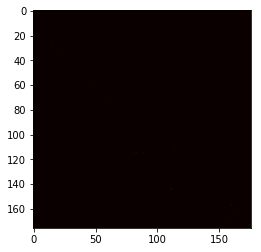

In [27]:
plt.imshow(occupancy_pairs_counts_sol_arr, cmap='hot', interpolation='nearest')

In [32]:
print({i: int(v) for i, v in occupancy_pairs_counts_sol.items() if v > 0})

{(125, 125): 49, (125, 278): 1, (125, 282): 1, (125, 293): 1, (128, 125): 1, (136, 125): 1, (140, 125): 2, (148, 136): 1, (149, 140): 1, (152, 140): 1, (159, 148): 1, (159, 149): 1, (163, 152): 1, (169, 159): 1, (170, 169): 1, (174, 163): 1, (181, 128): 1, (185, 174): 1, (187, 170): 1, (190, 181): 1, (195, 185): 1, (197, 187): 1, (199, 190): 1, (206, 195): 1, (207, 197): 1, (208, 199): 1, (214, 207): 1, (214, 219): 1, (219, 159): 1, (231, 240): 1, (236, 238): 1, (236, 239): 1, (238, 240): 1, (239, 240): 1, (240, 206): 1, (240, 208): 1, (240, 214): 2, (240, 246): 1, (243, 251): 1, (246, 254): 1, (251, 260): 1, (254, 240): 1, (259, 266): 1, (260, 240): 1, (266, 243): 1, (269, 236): 2, (272, 269): 1, (278, 259): 1, (279, 231): 1, (282, 285): 2, (285, 295): 2, (288, 290): 1, (290, 288): 1, (293, 272): 1, (295, 279): 1, (295, 282): 1, (297, 298): 1, (298, 299): 1, (299, 269): 1, (299, 297): 1, (300, 299): 1, (300, 300): 1}


In [34]:
df_occupancy_pairs_counts_sol = pd.DataFrame([(i[0], i[1], int(v)) for i, v in occupancy_pairs_counts_sol.items()], columns=['o', 'o_next', 'N'])
df_occupancy_pairs_counts_sol.head()

,o,o_next,N
0,125,125,49
1,125,126,0
2,125,127,0
3,125,128,0
4,125,129,0


In [29]:
out_going_occupancy_day_counts_sol = pd.Series({
    o: sum([occupancy_pairs_counts_sol[o, o_next] for o_next in allowed_occupancy])
    for o in allowed_occupancy
})
in_coming_occupancy_day_counts_sol = pd.Series({
    o_next: sum([occupancy_pairs_counts_sol[o, o_next] for o in allowed_occupancy])
    for o_next in allowed_occupancy
})

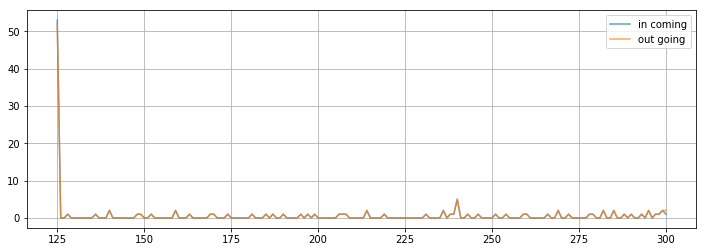

In [30]:
plt.figure(figsize=(12, 4))
plt.plot(in_coming_occupancy_day_counts_sol, alpha=0.7, label='in coming')
plt.plot(out_going_occupancy_day_counts_sol, alpha=0.7, label='out going')
plt.legend(); plt.grid(); plt.show()

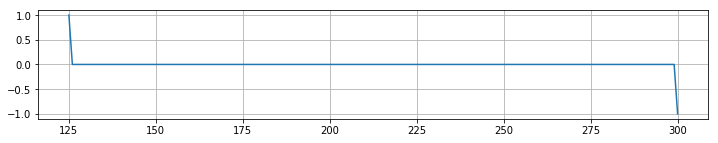

In [31]:
plt.figure(figsize=(12, 2))
plt.plot(in_coming_occupancy_day_counts_sol - out_going_occupancy_day_counts_sol)
plt.grid(); plt.show()